# Calculate wave height from IMU
putting all the resources in this folder together, we will go from raw IMU data in a dataframe to a calculated height estimate of a current smartfin ride and compare our results with the CDIP calculated heights

In [2]:
from smartfin_ride_api_v2 import Ride
from double_integral_bandpass import double_integral_bandpass_filter
import matplotlib.pyplot as plt
import random

ride = Ride()
idb = double_integral_bandpass_filter()

ride initialized


In [53]:
data = ride.get_ride_data('16196')

fetching ride from: https://surf.smartfin.org/ride/16196
fetching ocean data from: https://surf.smartfin.org/media/201908/google_115648017259601508520_000666D32250_190805004104_Ocean.CSV
fetching motion data from: https://surf.smartfin.org/media/201908/google_115648017259601508520_000666D32250_190805004104_Motion.CSV


C:\Users\evans\Desktop\Smartfin\smartfin_data_analysis\smartfin_ride_api_v2.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  odf['Time'] = [time / 1000 for time in odf['Time']]


calcualting start_time: 05/08/2019 00:41:13
calcualting end_time: 05/08/2019 01:57:13
retriving CDIP wave heights from: http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/archive/201p1/201p1_historic.nc
calculating significant wave height between 05/08/2019 00:41:13 - 05/08/2019 01:57:13
calculating significant wave height between 05/08/2019 00:41:13 - 05/08/2019 01:57:13
mean wave height: 0.6233333349227905
mean ocean temp: 22.433340072631836
retrieved nearest CDIP buoy: 201
retrieved CDIP means height for ride: [0.61, 0.63, 0.63]
retrieved CDIP means temp for ride: [22.440002, 22.429993, 22.440002, 22.429993, 22.480011, 22.49002, 22.52002, 22.51001, 22.450012, 22.429993, 22.420013, 22.399994, 22.360016, 22.360016, 22.339996]


# PROCESS DATA

## remove data from before and after surfer is in the water

In [54]:
# remove readings from ocean and motion dataframes where surfer is on land before entering the water
def remove_before_entrance(mdf, odf, threshold, med):
    
    # get temperature series
    temps = odf['Calibrated Temperature 1']
    enter_index = get_water_entrance_index(temps, threshold, med)
    
    # get the time where the surfer enters the water in the ocean dataframe
    startTime = odf.iloc[enter_index]['Time']
    
    # find the index in motion dataframe that matches with start index calculated from ocean dataframe
    startIdx = mdf.iloc[(mdf['Time']-startTime).abs().argsort()[:1]]
    return mdf.loc[startIdx.index[0]:], odf.tail(len(odf) - enter_index)
   

# calculate the index in ocean dataframe that the surfer enters the water
def get_water_entrance_index(temps, threshold, med):

    above = False
    count = 0
    consecutiveWithin = 0
    
    # calculate the index at the point where the temperature readings fall within the threshold consecutively
    for time, reading in temps.items():
        if abs(reading - med) < threshold:
            if above == True:
                above = False
            else:
                consecutiveWithin += 1
                
            # if the temperatures fall within the threshold consecutively, then we can assume the surfer is in the water
            if consecutiveWithin > 10:
                return count

            above = False

        else:
            above = True
            consecutiveWithin = 0
        count += 1 
        
    return firstInstance

# remove readings from ocean and motion dataframes where surfer is on land after exiting the water
def remove_after_exit(mdf, odf, threshold, med):

    # get the temperature series
    temps = odf['Calibrated Temperature 1']
    
    # get the index where surfer exits the water
    exit_index = get_water_exit_index(temps, threshold, med)
    
    # get the time where the surfer enters the water in the ocean dataframe
    endTime = odf.iloc[exit_index]['Time']

    # find the index in motion dataframe that matches with end index calculated from ocean dataframe
    endIdx = mdf.iloc[(mdf['Time']-endTime).abs().argsort()[:1]]
    return mdf.loc[:endIdx.index[0]], odf.head(exit_index)
   
    
# calculate the index in ocean dataframe that the surfer enters the water
def get_water_exit_index(temps, threshold, med):
    above = False
    count = 0

    # calculate the index at the last point where the temperature readings transition from within to outside the threshold 
    for time, reading in temps.items():
        if abs(reading - med) > threshold:
            
            # record index where temperature transition from within to outside the threshold
            if above == False:
                above = True
                firstInstance = count
            
            above = True
        
        else:
            above = False
            firstInstance = 0
        count += 1 
    
    return firstInstance



def get_water_data(mdf, odf):

    temps = odf['Calibrated Temperature 1']
    threshold = temps.std() / 2
    med = temps.median()
    
    mdf, odf = remove_before_entrance(mdf, odf, threshold, med)
    mdf, odf = remove_after_exit(mdf, odf, threshold, med)
    return mdf, odf


In [55]:
mdf = data['motion_data']
odf = data['ocean_data']
print(len(mdf))
print(len(odf))

4262
758


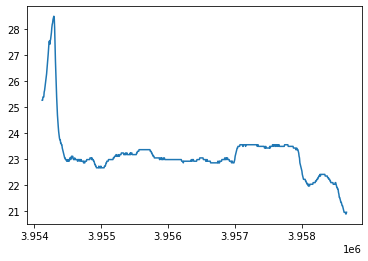

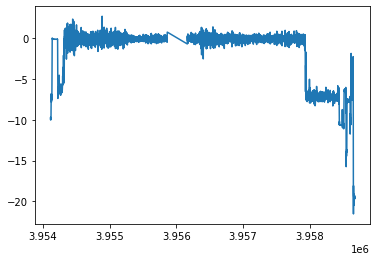

In [56]:
plt.plot(odf['Time'], odf['Calibrated Temperature 1'])
plt.show()
plt.plot(mdf['Time'], mdf['IMU A2'])
plt.show()

In [57]:
mdf, odf = get_water_data(mdf, odf)
print(len(mdf))
print(len(odf))
# mdf[1:100]

3230
586


,Time,IMU A1,IMU A2,IMU A3,IMU G1,IMU G2,IMU G3,IMU M1,IMU M2,IMU M3,TimeDelta
UTC,,,,,,,,,,,
2019-08-05 00:47:21+00:00,3.954484e+06,-1.058237,0.009577,0.009577,5.50,54.750000,13.750000,253.250000,-328.750000,1.250000,367877.666667
2019-08-05 00:47:22+00:00,3.954485e+06,-1.067814,-0.526724,-0.263362,31.25,-22.750000,-14.250000,244.750000,-325.250000,9.750000,368881.416667
2019-08-05 00:47:23+00:00,3.954486e+06,0.244209,0.359130,-1.771709,-1.75,-43.250000,21.250000,244.000000,-300.000000,36.000000,369881.166667
2019-08-05 00:47:24+00:00,3.954487e+06,-0.158017,0.110133,-1.489193,-121.50,-6.250000,2.500000,247.750000,-307.250000,27.250000,370875.916667
2019-08-05 00:47:25+00:00,3.954488e+06,-1.091756,-0.823605,0.555455,-132.50,3.500000,-48.500000,243.500000,-340.000000,-17.500000,371861.066667
...,...,...,...,...,...,...,...,...,...,...,...
2019-08-05 00:48:55+00:00,3.954578e+06,-0.905008,-0.368707,1.613692,52.50,-46.500000,58.500000,184.500000,-337.500000,-45.500000,461883.066667
2019-08-05 00:48:56+00:00,3.954578e+06,-1.532289,-0.082999,0.638454,-105.00,-7.333333,-76.333333,177.000000,-342.333333,-51.666667,462754.666667
2019-08-05 00:48:57+00:00,3.954579e+06,-1.068772,0.065122,0.746991,15.60,23.000000,25.800000,177.000000,-341.400000,-32.200000,463754.466667


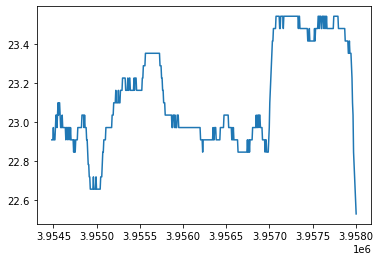

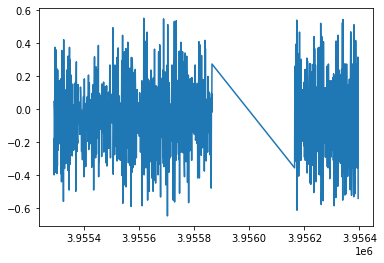

In [71]:
mdf_len = len(mdf)
mdf_quarter = mdf_len / 4
mdf_half = mdf_quarter * 2
mdf = mdf[int(mdf_quarter):int(mdf_half)]
plt.plot(odf['Time'], odf['Calibrated Temperature 1'])
plt.show()
plt.plot(mdf['Time'], mdf['IMU A2'])
plt.show()

## chunk data

In [59]:
def chunk_data(acc_array, time_array):
    chunk_len = 10
    times = []
    accs = []

    for i in range(int(len(acc_array) / chunk_len)):
        accs.append(acc_array[i*chunk_len:(i + 1)*chunk_len])
        times.append(time_array[i*chunk_len:(i + 1)*chunk_len])

    return accs, times, chunk_len

## filter bad values from IMU

In [60]:
def process_IMU(mdf):
    mean = mdf['IMU A2'].mean()
    std = mdf['IMU A2'].std()
    Upperbound = mean+(2.1*std)
    Lowerbound = mean-(2.1*std)
    Up = (mean+.5)
    Low = (mean-.5)
    mdf.loc[mdf['IMU A2'] > Upperbound, 'IMU A2'] = float(random.uniform(Up, Low))
    mdf.loc[mdf['IMU A2'] < Lowerbound, 'IMU A2'] = float(random.uniform(Up, Low))
    return mdf

## CALCULATE HEIGHT FROM PROCESS DATA

In [66]:
def get_ride_height(mdf):
    height_smartfin, height_list, height_sample_rate = calculate_ride_height(mdf)
    return height_smartfin



# these two functions are temporary and will be edited when we refine them
def calculate_ride_height(mdf): 
    mdf_len = len(mdf)
    mdf_quarter = mdf_len / 4
    mdf_half = mdf_quarter * 2
    mdf = mdf[int(mdf_quarter):int(mdf_half)]
    mdf = process_IMU(mdf)
    accs, times, chunk_len = chunk_data(mdf['IMU A2'], mdf['Time'])

    filter = double_integral_bandpass_filter()
    integral, displacements = filter.get_displacement_data(accs, times)
    
    # scalar multiplication
    print(f'calculated smartfin significant wave height: {integral}')
    print(f'height reading sample rate: {chunk_len}')
    integral = integral * 2.65
    return integral, displacements, chunk_len

In [67]:
height = calculate_ride_height(mdf)

calculated smartfin significant wave height: 1.1447674006269035
height reading sample rate: 10


In [68]:
CDIP_height = data['CDIP_height']

In [69]:
CDIP_height

0.62333333

In [70]:
height[0]

3.033633611661294